In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.0.0'

In [3]:
import tensorflow_datasets as tfds

### Importing Malaria dataset

In [4]:
# This was required because tfds.load('malaria') was giving a InsecureRequestWarning
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [5]:
mal_data = tfds.load('malaria')

##### Converting to numpy for data exploration

In [6]:
mal_data = tfds.as_numpy(mal_data)

In [7]:
len(mal_data)

1

In [8]:
type(mal_data)

dict

In [9]:
mal_data.keys()

dict_keys(['train'])

In [10]:
mal_data.values()

dict_values([<generator object _eager_dataset_iterator at 0x7f3d0c49d830>])

In [11]:
mal_data_npy = mal_data['train']

In [12]:
type(mal_data_npy)

generator

In [13]:
for i in mal_data_npy:
  temp = i
  print(i)
  break

{'image': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 'label': 1}


In [14]:
feature_list = []
label_list = []
for i in mal_data_npy:
  feature_list.append(i['image'])
  label_list.append(i['label'])

In [15]:
len(feature_list)

27557

In [16]:
feature_list.append(temp['image'])
label_list.append(temp['label'])

In [17]:
len(label_list)

27558

#### Plotting

In [18]:
import matplotlib.pyplot as plt

%matplotlib inline

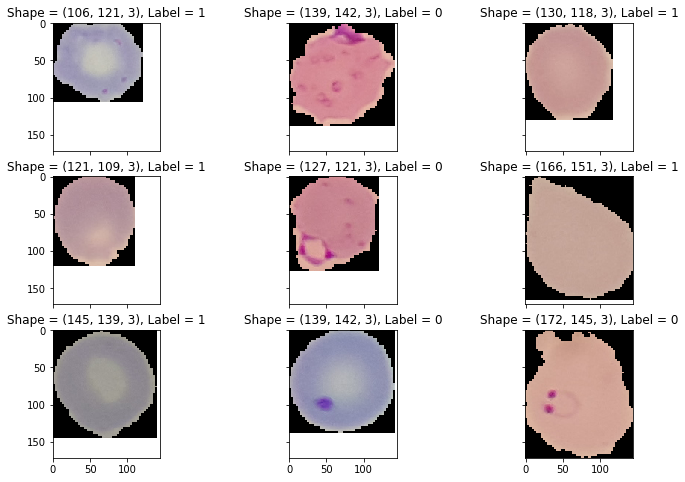

In [19]:
fig1, ax1 = plt.subplots(3,3, sharex=True, sharey=True, figsize = (12,8))
ax1 = ax1.flatten()
for i,j,k in zip(range(len(ax1)), feature_list, label_list):
  ax1[i].imshow(j)
  ax1[i].set_title('Shape = ' + str(j.shape) + ', Label = ' + str(k))
plt.show()

  * Different input sizes but all with 3 channels

### Data Preprocessing

In [20]:
import numpy as np

In [21]:
feature_list = np.array(feature_list)

In [22]:
feature_list[0].shape

(106, 121, 3)

In [23]:
label_list = np.array(label_list)

In [24]:
label_list = label_list.astype('uint8')

#### <br /> Checking the image size (height, width) distribution <br />


In [25]:
shape_list = []
for i in feature_list:
  shape = i.shape
  shape_list.append([shape[0], shape[1]])

shape_list = np.array(shape_list)

In [26]:
shape_list.shape

(27558, 2)

In [27]:
# Minimum dimension size (height, width)
min_shape_val = np.min(shape_list, axis=0)
min_shape_val

array([40, 46])

In [28]:
# Maximum dimension size (height, width)
max_shape_val = np.max(shape_list, axis=0)
max_shape_val

array([385, 394])

In [29]:
# Mean dimension size (height, width)
mean_shape_val = np.mean(shape_list, axis=0)
mean_shape_val

array([132.98345308, 132.48715437])

In [30]:
# standard deviation of the dimension size (height, width)
std_shape_val = np.std(shape_list, axis=0)
std_shape_val

array([20.61927562, 20.01558555])

In [31]:
# median of the dimension size (height, width)
median_shape_val = np.median(shape_list, axis=0)
median_shape_val

array([130., 130.])

  * Since the standard deviation is not too high, the mean size of the image size can be used to resize all the images to one standard size

In [32]:
resize = np.round(mean_shape_val).astype('uint8')
resize

array([133, 132], dtype=uint8)

##### memory consumption till here is 1.6 GB <br />

        * All images need to be resized to the same dimension (height, width) for creating a tf.data.Dataset object
       
        
        

##### using tf.image module, with the option of various resizes methods, to resize the images

In [33]:
# timeit module to time the whole script
import time

def resizing_fn(feature_list):
    
    start_time = time.time()

    resized_feature_list = []
    for i,j in enumerate(feature_list):
        img_resize = tf.image.resize_with_pad(j, resize[0], resize[1], method = 'lanczos3', antialias=True)
        resized_feature_list.append(img_resize.numpy())

    end_time = time.time()
    time_for_resizing = end_time - start_time

    print('Time taken for resizing: %0.1f seconds' %(end_time - start_time))
    
    return np.array(resized_feature_list)

In [34]:
import gc

start_time = time.time()

resized_feature_list = []
for i in feature_list:
    img_resize = tf.image.resize_with_pad(i, resize[0], resize[1], method = 'lanczos3', antialias=True)
    resized_feature_list.append(img_resize)

end_time = time.time()
time_for_resizing = end_time - start_time

print(time_for_resizing) # time the resizing operation in seconds


In [35]:
from joblib import Parallel, delayed
def resizing_tf(i):
    
    return tf.image.resize_with_pad(image = i, target_height = resize[0], 
                                    target_width=resize[1], method = 'lanczos3', antialias=True).numpy()
def resizing_fn(feature_list):
    
    start_time = time.time()
    
    resized_feature_list = Parallel(n_jobs=3)(delayed(resizing_tf)(i) for i in feature_list)
    
    end_time = time.time()
    
    print('Time taken for resizing: %0.1f seconds' %(end_time - start_time))
    
    return np.array(resized_feature_list)

    
Using joblib to parallelize reduces the processing time for sure but results in RAM consumption 
going up twice the amount than a standard loop.

Also, unable to clear memory using

    del resized_feature_list
    gc.collect()

tested by defining within the function itself <br />

Time taken for resizing: 2.2 seconds


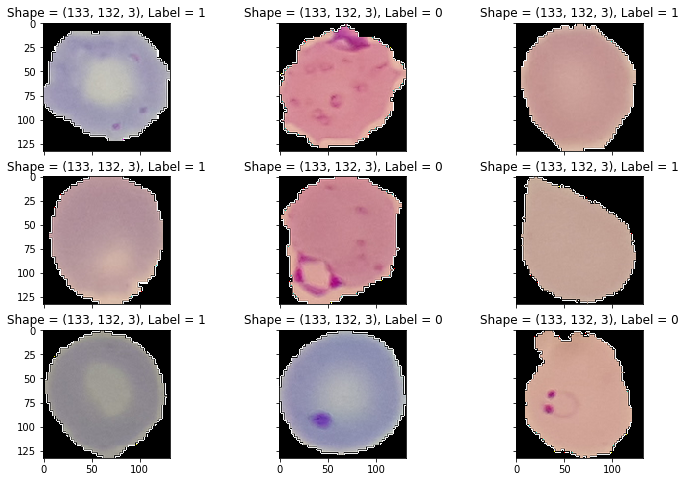

In [36]:
# Plotting the resized images
fig2, ax2 = plt.subplots(3,3, sharex=True, sharey=True, figsize = (12,8))
ax2 = ax2.flatten()

for i,j,k in zip(range(len(ax2)), resizing_fn(feature_list[:9]), label_list):
    ax2[i].imshow(tf.cast(j, 'uint8')) # plt.imshow clips input data to range [0,255] for integers
    ax2[i].set_title('Shape = ' + str(j.shape) + ', Label = ' + str(k))

plt.show()

### Creating TF dataset for training

##### Shuffling the data before splitting into training, validation and test in the ratio 0.8,0.1,0.1

In [37]:
# concat_data = np.concatenate((feature_list.reshape(-1,1), label_list.reshape(-1,1)), axis=1)
# concat_data.shape

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
random_seed = 100

In [40]:
x_train, x_test, y_train, y_test = train_test_split(resizing_fn(feature_list), label_list, test_size=0.1, shuffle = True, 
                                                    random_state=random_seed, stratify = label_list)

Time taken for resizing: 52.9 seconds


In [41]:
len(x_train)

24802

In [42]:
len(x_test)

2756

In [43]:
# validation size will be
1/9

0.1111111111111111

In [44]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.11, shuffle = True, 
                                                    random_state=random_seed, stratify = y_train)

In [45]:
len(x_train)

22073

In [46]:
len(x_valid)

2729

#### Creating a tf.data dataset

In [47]:
input_label = 'image'
output_label = 'disease_label'

In [48]:
starttime =time.time()
train_dataset = tf.data.Dataset.from_tensor_slices(({input_label:x_train}, {output_label:y_train}))
endtime = time.time()

In [49]:
endtime-starttime

2.537196159362793

In [50]:
for i in train_dataset.take(1):
    print(i)

({'image': <tf.Tensor: id=55287, shape=(133, 132, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>}, {'disease_l

In [51]:
validation_dataset = tf.data.Dataset.from_tensor_slices(({input_label:x_valid}, {output_label:y_valid}))
test_dataset = tf.data.Dataset.from_tensor_slices(({input_label:x_test}, {output_label:y_test}))

        * Huge increase in memory consumption. Total is 1.6 GB + 5.4 GB + 6.0 GB

In [52]:
del x_train, x_test, x_valid
gc.collect()

245

Testing

#### Scope and Namespace tests

"del resized_feature_list" <br /> By deleting the variable, the process only deletes the binding between the name and the object while the object still remains

In [53]:
def scope_test():
    def do_local():
        spam = "local spam"

    def do_nonlocal():
        nonlocal spam
        spam = "nonlocal spam"

    def do_global():
        global spam
        spam = "global spam"

        
    spam = "test local spam"
    do_local()
    print("After local assignment:", spam)
    
    do_nonlocal()
    print("After nonlocal assignment:", spam)

    spam = "test nonlocal spam"
    print("After nonlocal assignment:", spam)

    do_global()
    print("After global assignment:", spam)

scope_test()
print("In global scope:", spam)

After local assignment: test local spam
After nonlocal assignment: nonlocal spam
After nonlocal assignment: test nonlocal spam
After global assignment: test nonlocal spam
In global scope: global spam
